In [135]:
#Importing Libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [136]:
# #read the text file
# path = "data2.txt"
# f = open(path, 'r', encoding='utf-8')
# data = f.read()
# print(data)

In [137]:
#read the text file
d = open('data3.txt','r',encoding='utf-8')
data = d.read()
data 

'21/10/22, 7:29\u202fpm - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.\n21/10/22, 7:29\u202fpm - Suresh Cse Gmr created group "Beware Batch"\n21/10/22, 7:29\u202fpm - Suresh Cse Gmr added you\n21/10/22, 7:30\u202fpm - Suresh Cse Gmr: Hai\n21/10/22, 7:30\u202fpm - You\'re now an admin\n21/10/22, 7:38\u202fpm - Leela Prasad.....💥👑👑: Rey maxi cab avvadu anta aa route\n21/10/22, 7:39\u202fpm - Rohith BavaMaridi: Check istha randi\n21/10/22, 7:39\u202fpm - Rohith BavaMaridi: Eroju\n21/10/22, 7:41\u202fpm - Rohith BavaMaridi: Innova bro\n21/10/22, 8:17\u202fpm - Leela Prasad.....💥👑👑: Rey mawa ame chadam\n@918074325038 \n\n@917680977418\n21/10/22, 8:18\u202fpm - Harsha Roommate: Orey Bokulu reply ivandi\n21/10/22, 8:22\u202fpm - You added Chandu Cse Gmr and Prem Roommate\n21/10/22, 8:23\u202fpm - Chandu Cse Gmr: avarra merantha\n21/10/22, 8:23\u202fpm - Prem Roommate: <Media omitted>\n21/10/22, 9:17

In [138]:

# Regular expression pattern
pattern = r'(\d{1,2}\/\d{1,2}\/\d{2}),?\s(\d{1,2}:\d{2})\s?(am|pm)?\s-\s(.+?):\s(.+)'

# Create an empty list to store the rows of the DataFrame
rows = []

# Loop over the messages and extract the date, time, am/pm, username, and message using the pattern
for message in data.split('\n'):
    match = re.search(pattern, message)
    if match is not None:
        date = match.group(1)
        time = match.group(2)
        ampm = match.group(3)
        username = match.group(4)
        msg = match.group(5)
    
        # Append the row to the list
        rows.append({
            'only_date': date,
            't': time,
            'ampm' : ampm,
            'username': username,
            'message': msg
        })

# Create a Pandas DataFrame from the list of rows
df = pd.DataFrame(rows)

In [139]:
df['only_date'] = pd.to_datetime(df['only_date'], format='%d/%m/%y')
# Convert the date column to the '%Y-%m-%d' format
df['only_date'] = df['only_date'].dt.strftime('%Y-%m-%d')

In [140]:
# converting into 24hrs
df['time'] = df.apply(lambda x: f"{x['t']} {x['ampm']}", axis=1)

df = df.drop(['t', 'ampm'], axis=1)

In [141]:
def convert_time(time_str):
    time_obj = pd.to_datetime(time_str, format='%I:%M %p')
    return time_obj.strftime('%H:%M')

df['only_time'] = df['time'].apply(convert_time)

# Drop the original 'time' column if desired
df = df.drop('time', axis=1)


In [142]:
# converting into 24hrs
df['date'] = df.apply(lambda x: f"{x['only_date']} {x['only_time']}", axis=1)

In [143]:
df[['year', 'month_num', 'day']] = df['only_date'].str.split('-', expand=True)


In [144]:
# Convert the month number to month name
df['month'] = pd.to_datetime(df['month_num'], format='%m').dt.strftime('%B')

# Convert the date to day name
df['day_name'] = pd.to_datetime(df['only_date']).dt.strftime('%A')

In [145]:
# Split the time column into two separate columns for hour and minute
df[['hour', 'minute']] = df['only_time'].str.split(':', expand=True)

In [146]:
df

,only_date,username,message,only_time,date,year,month_num,day,month,day_name,hour,minute
0,2022-10-21,Suresh Cse Gmr,Hai,19:30,2022-10-21 19:30,2022,10,21,October,Friday,19,30
1,2022-10-21,Leela Prasad.....💥👑👑,Rey maxi cab avvadu anta aa route,19:38,2022-10-21 19:38,2022,10,21,October,Friday,19,38
2,2022-10-21,Rohith BavaMaridi,Check istha randi,19:39,2022-10-21 19:39,2022,10,21,October,Friday,19,39
3,2022-10-21,Rohith BavaMaridi,Eroju,19:39,2022-10-21 19:39,2022,10,21,October,Friday,19,39
4,2022-10-21,Rohith BavaMaridi,Innova bro,19:41,2022-10-21 19:41,2022,10,21,October,Friday,19,41
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,2023-03-07,Leela Prasad.....💥👑👑,Already seen,22:56,2023-03-07 22:56,2023,03,07,March,Tuesday,22,56
1306,2023-03-07,Prem Roommate,Ohoh,22:56,2023-03-07 22:56,2023,03,07,March,Tuesday,22,56
1307,2023-03-08,Leela Prasad.....💥👑👑,Rey attendance vestunara raa,11:10,2023-03-08 11:10,2023,03,08,March,Wednesday,11,10
1308,2023-03-08,Leela Prasad.....💥👑👑,Class ki randi,11:11,2023-03-08 11:11,2023,03,08,March,Wednesday,11,11


In [147]:
#add period column that shows data capture between which 24 hour format
period = []
for hour in df[['day_name', 'hour']]['hour']:
    h = int(hour)+1
    if hour == 23:
        period.append(str(hour) + "-" + str('00'))
    elif hour == 0:
        period.append(str('00') + "-" + str(hour + 1))
    else:
        period.append(str(hour) + "-" + str(h))
df['period'] = period

In [148]:
df

,only_date,username,message,only_time,date,year,month_num,day,month,day_name,hour,minute,period
0,2022-10-21,Suresh Cse Gmr,Hai,19:30,2022-10-21 19:30,2022,10,21,October,Friday,19,30,19-20
1,2022-10-21,Leela Prasad.....💥👑👑,Rey maxi cab avvadu anta aa route,19:38,2022-10-21 19:38,2022,10,21,October,Friday,19,38,19-20
2,2022-10-21,Rohith BavaMaridi,Check istha randi,19:39,2022-10-21 19:39,2022,10,21,October,Friday,19,39,19-20
3,2022-10-21,Rohith BavaMaridi,Eroju,19:39,2022-10-21 19:39,2022,10,21,October,Friday,19,39,19-20
4,2022-10-21,Rohith BavaMaridi,Innova bro,19:41,2022-10-21 19:41,2022,10,21,October,Friday,19,41,19-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,2023-03-07,Leela Prasad.....💥👑👑,Already seen,22:56,2023-03-07 22:56,2023,03,07,March,Tuesday,22,56,22-23
1306,2023-03-07,Prem Roommate,Ohoh,22:56,2023-03-07 22:56,2023,03,07,March,Tuesday,22,56,22-23
1307,2023-03-08,Leela Prasad.....💥👑👑,Rey attendance vestunara raa,11:10,2023-03-08 11:10,2023,03,08,March,Wednesday,11,10,11-12
1308,2023-03-08,Leela Prasad.....💥👑👑,Class ki randi,11:11,2023-03-08 11:11,2023,03,08,March,Wednesday,11,11,11-12


In [149]:
#Total Messages
df.shape[0]

1310

In [150]:
#Total Number of words
words = []
for message in df['message']:
  words.extend(message.split())

print(len(words))

3621


In [151]:
#Number of Media Files shared
df[df['message'] == '<Media omitted>'].shape[0]

540

In [152]:
#Number of Links Shared
from urlextract import URLExtract
extract = URLExtract()

links = []
for message in df['message']:
    links.extend(extract.find_urls(message))

print(len(links))

21


c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128081 (\N{CROWN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


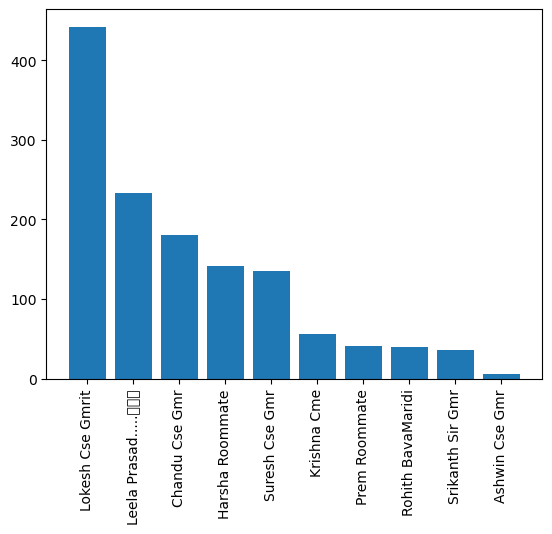

In [163]:
import matplotlib.pyplot as plt

x = df['username'].value_counts()
user_names = x.index
msg_count = x.values

plt.bar(user_names, msg_count)
plt.xticks(rotation='vertical')
plt.show()

In [162]:
new_df = round(((df['username'].value_counts() / df.shape[0]) * 100), 2).reset_index().rename(
        columns={'index': 'name', 'user': 'percent'})

new_df

,name,username
0,Lokesh Cse Gmrit,33.74
1,Leela Prasad.....💥👑👑,17.79
2,Chandu Cse Gmr,13.74
3,Harsha Roommate,10.76
4,Suresh Cse Gmr,10.31
5,Krishna Cme,4.27
6,Prem Roommate,3.13
7,Rohith BavaMaridi,3.05
8,Srikanth Sir Gmr,2.75
9,Ashwin Cse Gmr,0.46


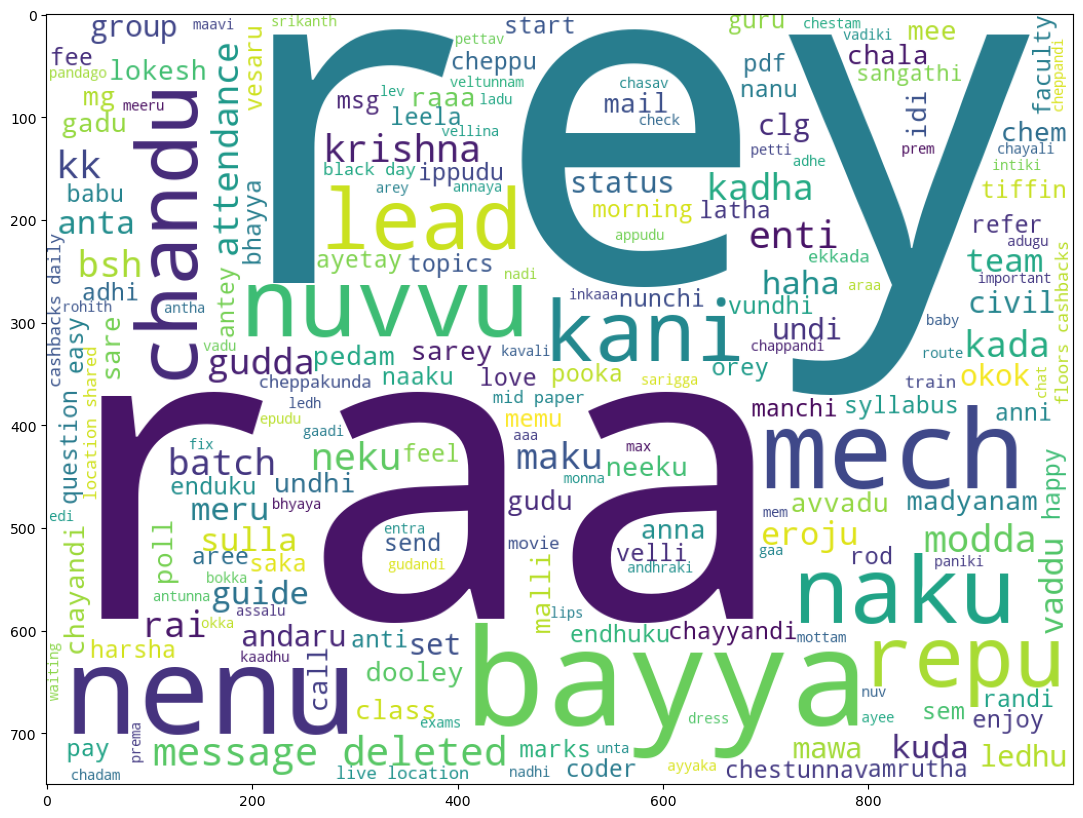

In [166]:
import string

def remove_stop_words(message):
  f = open('stop_hinglish.txt', 'r')
  stop_words = f.read()
  y = []
  for word in message.lower().split():
      if word not in stop_words:
          y.append(word)
  return " ".join(y)

def remove_punctuation(message):
  x = re.sub('[%s]'% re.escape(string.punctuation), '', message)
  return x

#Data Cleaning
temp = df[df['username'] != 'group_notification'] #remove group notification
temp = temp[temp['message'] != '<Media omitted>'] #remove media message
temp['message'] = temp['message'].apply(remove_stop_words) #remove stopwords
temp['message'] = temp['message'].apply(remove_punctuation) #remove punctuations

#Draw the wordCloud
from wordcloud import WordCloud
plt.figure(figsize=(20, 10))
wc = WordCloud(width=1000,height=750,min_font_size=10,background_color='white')
cloud = wc.generate(temp['message'].str.cat(sep=" "))
plt.imshow(cloud)

In [167]:
#Find the Top 20 Most Common Words

temp = df[df['username'] != 'group_notification'] #remove group notification
temp = temp[temp['message'] != '<media omitted>']  #remove media msg
temp['message'] = temp['message'].apply(remove_stop_words) #remove stop words
temp['message'] = temp['message'].apply(remove_punctuation) #remove punctuations

words = []
for message in temp['message']:
  words.extend(message.split())

#apply counter
from collections import Counter
most_common_df = pd.DataFrame(Counter(words).most_common(20))
most_common_df

,0,1
0,media,540
1,omitted,540
2,rey,61
3,raa,51
4,bayya,25
5,nenu,20
6,😅,16
7,mech,16
8,nuvvu,12
9,naku,11


In [157]:
import emoji

emojis = []
for message in df['message']:
  emojis.extend([c for c in message if c in emoji.EMOJI_DATA])

pd.DataFrame(Counter(emojis).most_common(len(Counter(emojis))))

,0,1
0,😅,20
1,😂,20
2,😁,11
3,🙄,8
4,🤣,8
5,😀,7
6,🫰,7
7,🙏,5
8,🤙,5
9,🍾,4


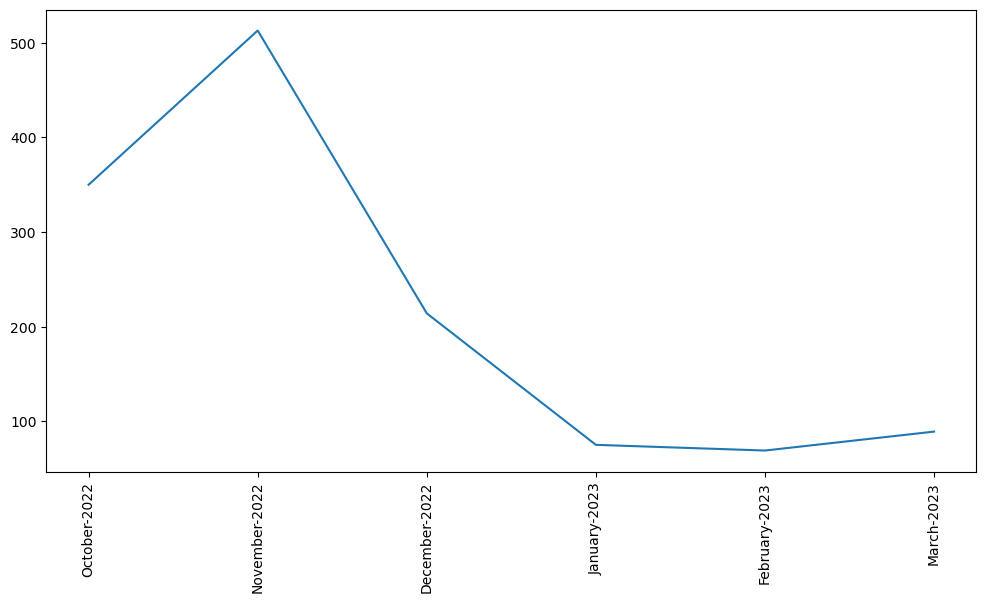

In [158]:
#Time-based Analysis

#Monthly Chats Timeline

timeline = df.groupby(['year', 'month_num', 'month']).count()['message'].reset_index()
month_timeline = []

for i in range(timeline.shape[0]):
  month_timeline.append(timeline['month'][i] + "-" + str(timeline['year'][i]))

timeline['time'] = month_timeline

#draw plot
plt.figure(figsize=(12,6))
plt.plot(timeline['time'], timeline['message'])
plt.xticks(rotation='vertical')
plt.show()

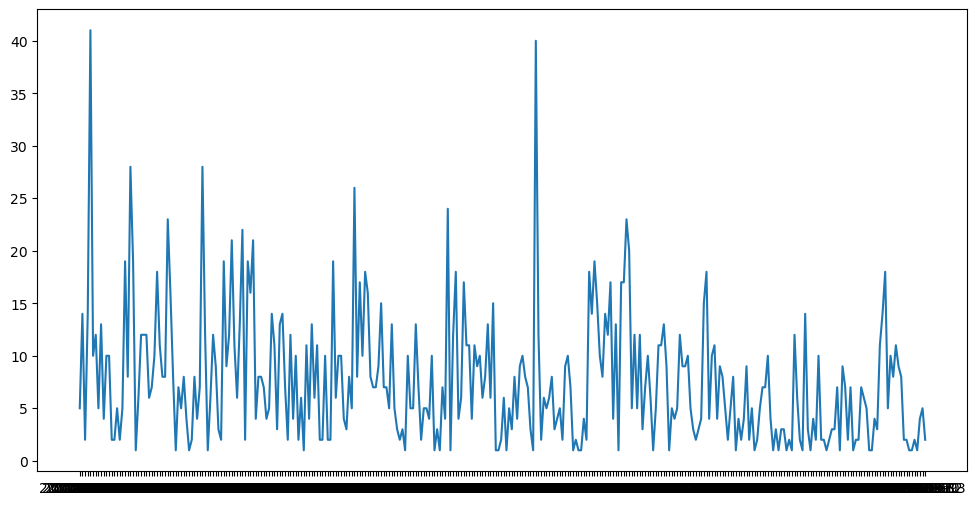

In [117]:
#Daily Timeline

daily_timeline = df.groupby('only_date').count()['message'].reset_index()

plt.figure(figsize=(12,6))
plt.plot(daily_timeline['only_date'], daily_timeline['message'])
plt.show()


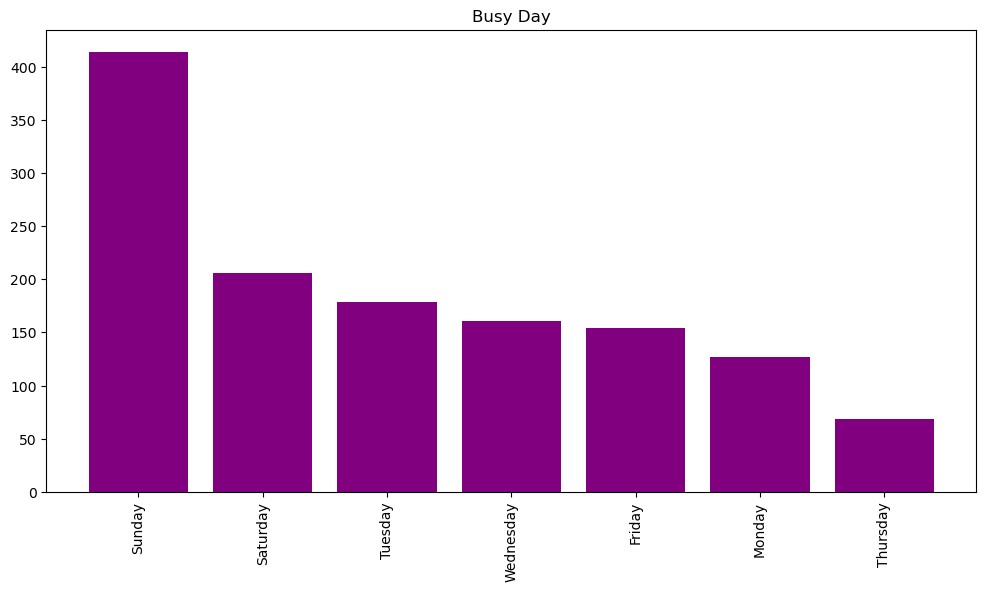

In [159]:
#Day-based Activity Map

busy_day = df['day_name'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(busy_day.index, busy_day.values, color='purple')
plt.title("Busy Day")
plt.xticks(rotation='vertical')
plt.show()

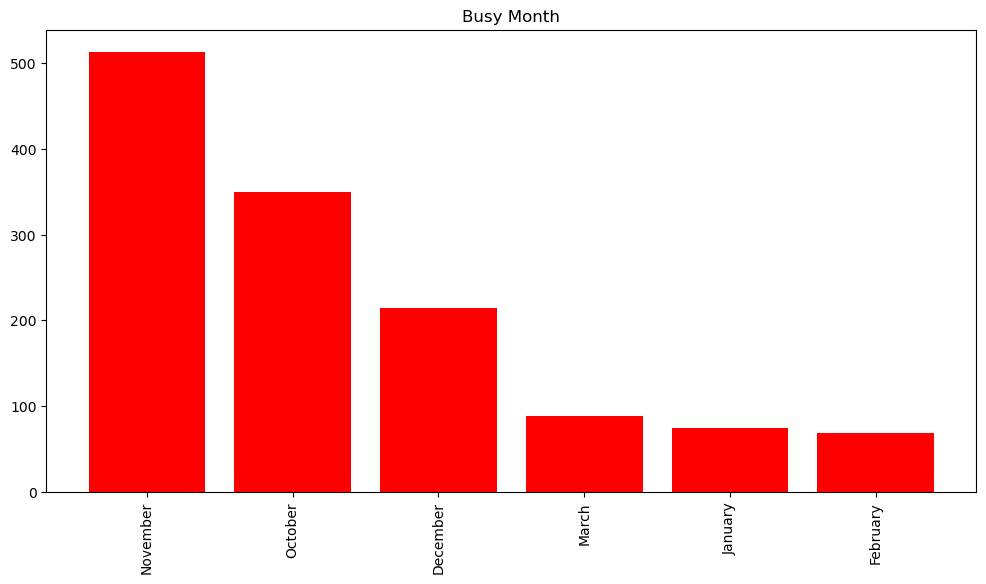

In [160]:
#Monthly Activity Map

busy_month = df['month'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(busy_month.index, busy_month.values, color='red')
plt.title("Busy Month")
plt.xticks(rotation='vertical')
plt.show()

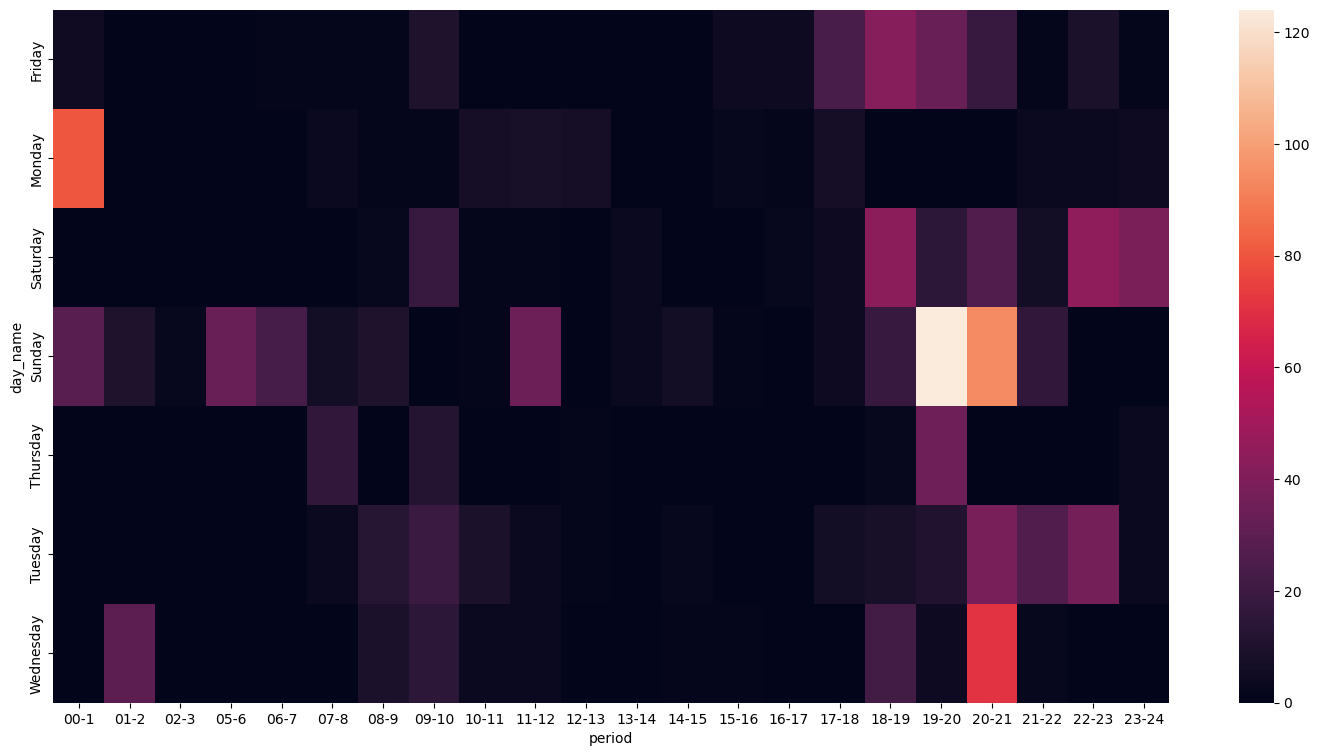

In [161]:
#Which Time User Remains Active

import seaborn as sns
plt.figure(figsize=(18, 9))
sns.heatmap(df.pivot_table(index='day_name', columns='period', values='message', 
            aggfunc='count').fillna(0))
plt.yticks(rotation='vertical')
plt.show()